In [6]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd

In [7]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [8]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [9]:
def adaptive_kdj_factor(df, volatility_window=20):
    # Calculate log returns safely
    returns = np.log(df['close']).diff()
    
    # Calculate rolling volatility with min_periods to avoid initial NaNs
    vol = returns.rolling(volatility_window, min_periods=1).std()
    
    # Handle any remaining NaNs/Infs robustly
    vol = vol.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(0.01)
    
    # Convert to integer period between 5 and 20
    n_period = (vol * 100).clip(5, 20).astype(int)
    
    # Precompute rolling min/max for all required periods
    periods = list(range(5, 21))
    min_df = pd.DataFrame({p: df['low'].rolling(p, min_periods=1).min() for p in periods})
    max_df = pd.DataFrame({p: df['high'].rolling(p, min_periods=1).max() for p in periods})
    
    # Extract appropriate values using vectorized operations
    col_idx = (n_period - 5).values
    row_idx = np.arange(len(df))
    low_min = min_df.values[row_idx, col_idx]
    high_max = max_df.values[row_idx, col_idx]
    
    # Compute RSV safely
    denom = high_max - low_min
    rsv = 100 * (df['close'].values - low_min) / np.where(denom < 1e-8, np.nan, denom)
    rsv = pd.Series(rsv, index=df.index).fillna(50.0)  # Neutral value when denom≈0
    
    # Compute K-line (EMA of RSV)
    K = rsv.ewm(span=3, adjust=False, min_periods=1).mean()
    
    # Center using expanding mean without look-ahead bias
    mean_so_far = K.expanding().mean().shift(1).fillna(50.0)
    return K - mean_so_far

In [10]:
evaluator.set_factor(
    factor_data_or_func=adaptive_kdj_factor,
    factor_name='adaptive_kdj_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.004716
   Rank_IC (Spearman): -0.021946
📊 信息比率:
   IR: 0.689231
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130368
   因子列: adaptive_kdj_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


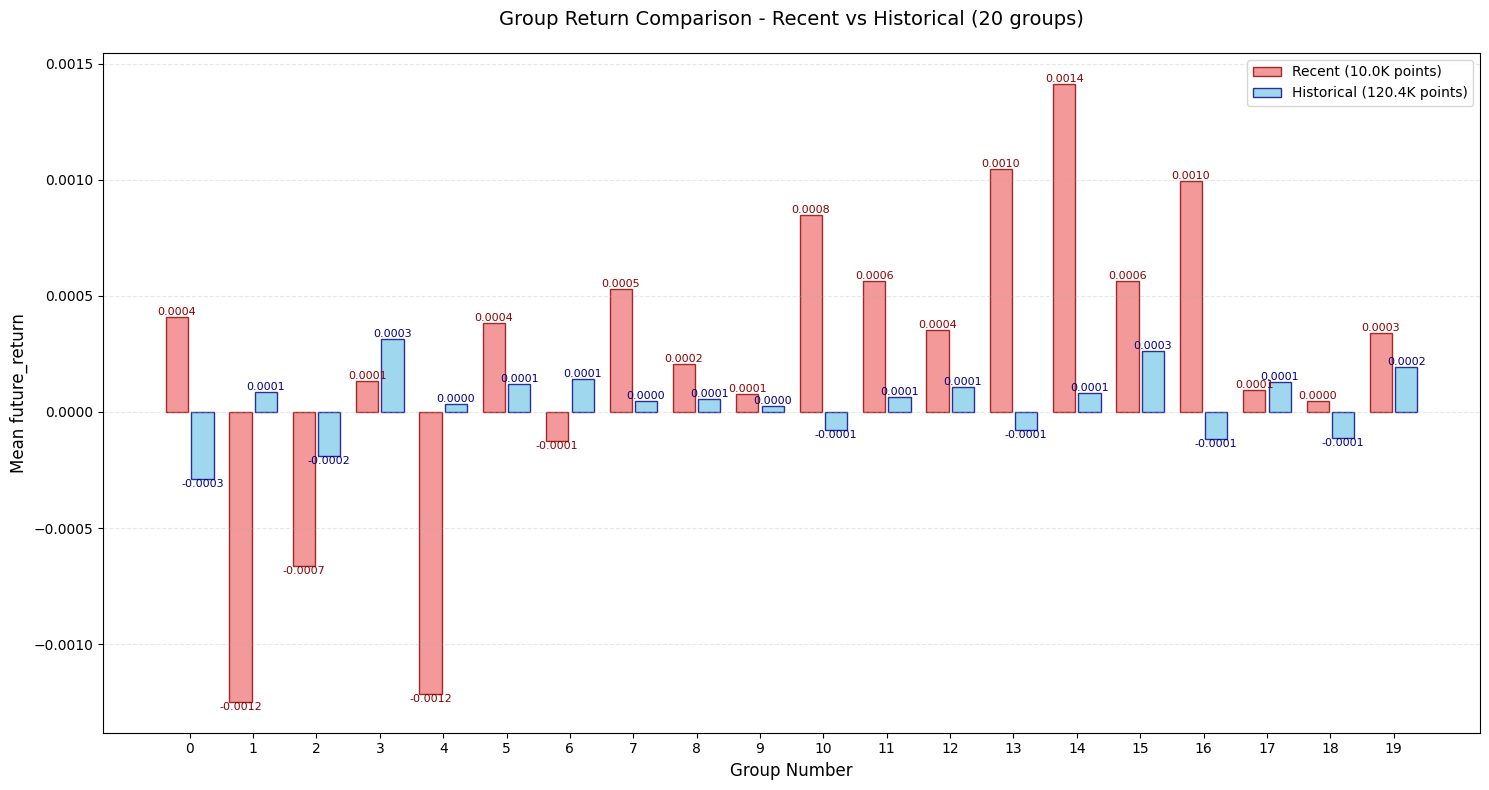

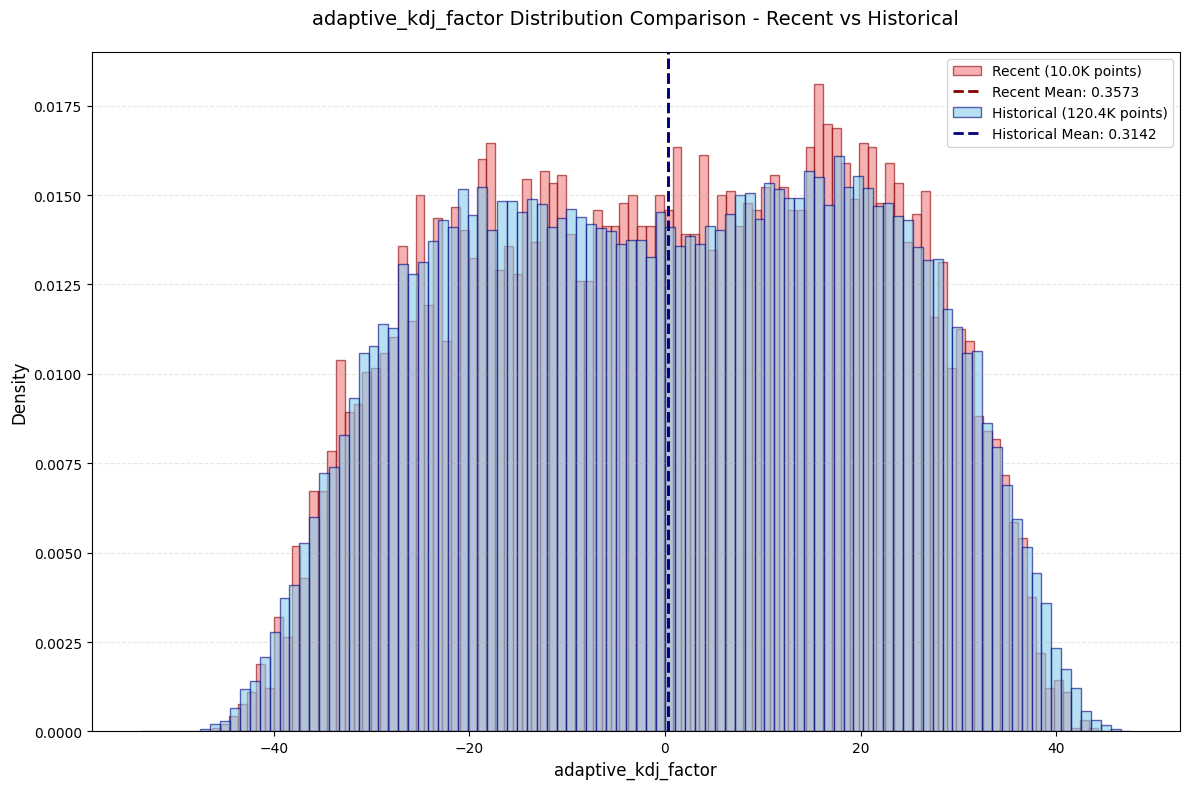

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [11]:
result=evaluator.run_full_evaluation(run_stationarity_test=True)